In [ ]:
!pip install imagededup

# Duplicates image identification

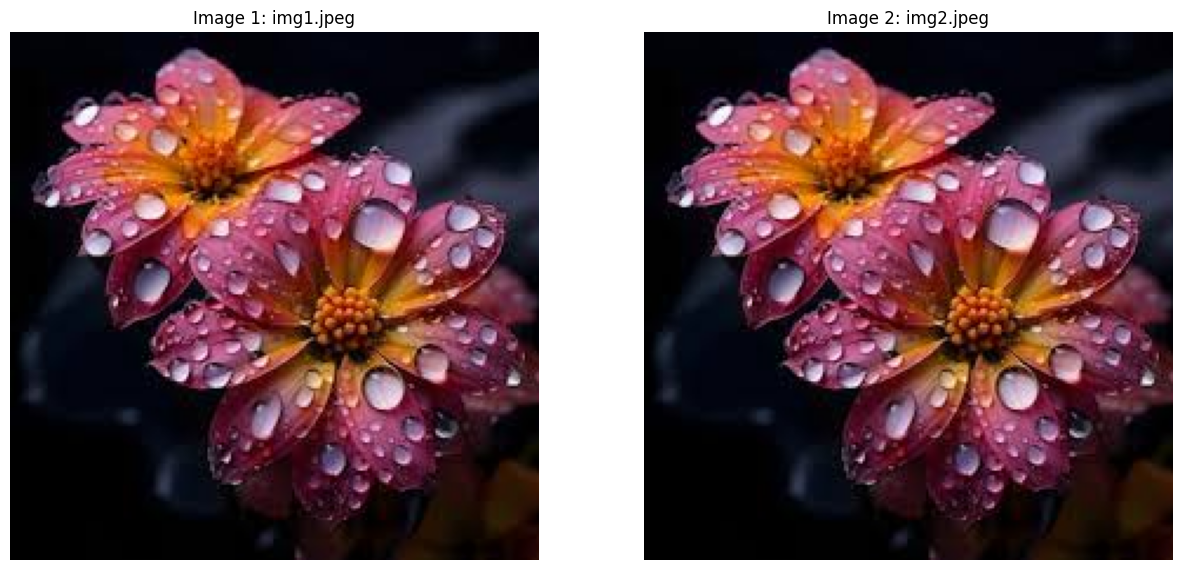

The images '/content/drive/MyDrive/images1/img8.jpeg' and '/content/drive/MyDrive/images1/img9.jpeg' are duplicates.


In [24]:
from imagededup.methods import DHash
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Set plot parameters
plt.rcParams['figure.figsize'] = (15, 10)

dhash = DHash()
image1_path = "/content/drive/MyDrive/images1/img8.jpeg"
image2_path = "/content/drive/MyDrive/images1/img9.jpeg"

# Encode each image using DHash
hash1 = dhash.encode_image(image_file=image1_path)
hash2 = dhash.encode_image(image_file=image2_path)

def calculate_hamming_distance(hash1, hash2):
    # Convert the hashes to numpy arrays
    h1 = np.array(list(hash1))
    h2 = np.array(list(hash2))

    # Calculate the number of differing bits
    return np.sum(h1 != h2)

# Compute Hamming distance between the two hash encodings
hamming_distance = calculate_hamming_distance(hash1, hash2)

# Threshold for duplicate detection (0 means exact duplicate, higher values allow small differences)
threshold = 0

# Load and display both images
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Convert images from BGR (OpenCV format) to RGB for displaying in matplotlib
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display both images side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1_rgb)
axes[0].set_title('Image 1: img1.jpeg')
axes[0].axis('off')

axes[1].imshow(image2_rgb)
axes[1].set_title('Image 2: img2.jpeg')
axes[1].axis('off')

plt.show()

# Check if the two images are duplicates
if hamming_distance == threshold:
    print(f"The images '{image1_path}' and '{image2_path}' are duplicates.")
else:
    print(f"The images '{image1_path}' and '{image2_path}' are not duplicates.")

# print(f"Hamming distance: {hamming_distance}")


# Similarity

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

def classify_image_similarity(image_path1, image_path2):
    # Load pretrained ResNeXt model
    model = models.resnext50_32x4d(pretrained=True)
    model.eval()

    # Image transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    def load_image(image_path):
        image = Image.open(image_path).convert('RGB') # convert image to RGB
        return preprocess(image).unsqueeze(0)

    first_img = load_image(image_path1)
    secong_img = load_image(image_path2)

    # Forward pass through the model
    with torch.no_grad():
        output1 = model(first_img)
        output2 = model(secong_img)

    # Compare the outputs
    similarity = torch.nn.functional.cosine_similarity(output1, output2)
    similarity_score = similarity.item()

    # Display images
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')

    plt.suptitle(f"Similarity Score: {similarity_score:.2f}")
    plt.show()

    # Print similarity result with a threshold of 0.90
    if similarity_score >= 0.9 and similarity_score < 1:  # Threshold for similarity
        print("Images are similar.")
    else:
        print("These are not similar images. They may be duplicates or different images.")

# Use the function with the image paths
classify_image_similarity('/content/drive/MyDrive/images1/img23.jpg', '/content/drive/MyDrive/images1/img22.jpg')


# looking same but different images

No cropped image detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Combined Feature Similarity (Cosine Similarity): 0.55
SSIM Score: 0.23


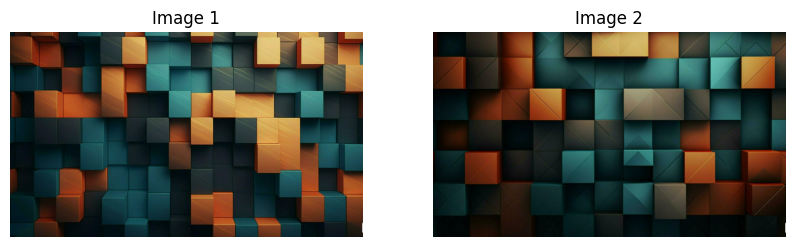

Both images look the same but are actually different.


In [25]:
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from skimage.feature import hog
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Check if the image is cropped or duplicate using template matching
def is_cropped(original_image_path, cropped_image_path):
    # Load images
    img1 = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(cropped_image_path, cv2.IMREAD_GRAYSCALE)

    # Perform template matching
    result = cv2.matchTemplate(img1, img2, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Threshold for template matching
    threshold = 0.82
    if max_val > threshold:
        print("The image is cropped or duplicate.")
        return True  # Cropped or duplicate detected
    else:
        print("No cropped image detected.")
        return False  # Proceed with other checks

# VGG16 for Deep Learning Feature Extraction
def extract_features_vgg16(img_path):
    model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = model.predict(img_array)
    features = features.flatten()  # Flatten to a 1D vector
    return features

# HOG (Histogram of Oriented Gradients) for capturing structural info
def extract_features_hog(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128))  # Resize to a smaller size
    features, _ = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    return features

# SSIM for structural similarity
def compute_ssim(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    img1_resized = cv2.resize(img1, (224, 224))
    img2_resized = cv2.resize(img2, (224, 224))
    score, _ = ssim(img1_resized, img2_resized, full=True)
    return score

# Main comparison function
def compare_images(image1_path, image2_path):
    # First, check if one image is a cropped version of the other
    if is_cropped(image1_path, image2_path):
        print("Images are cropped or duplicates, no further comparison needed.")
        return

    # If no cropping detected, proceed with VGG16, HOG, and SSIM checks

    # Extract features from VGG16
    features_vgg1 = extract_features_vgg16(image1_path)
    features_vgg2 = extract_features_vgg16(image2_path)

    # Extract features using HOG
    features_hog1 = extract_features_hog(image1_path)
    features_hog2 = extract_features_hog(image2_path)

    # Combine the feature vectors
    combined_features1 = np.concatenate([features_vgg1, features_hog1])
    combined_features2 = np.concatenate([features_vgg2, features_hog2])

    # Compute cosine similarity between combined feature vectors
    cosine_sim = cosine_similarity([combined_features1], [combined_features2])[0][0]
    print(f"Combined Feature Similarity (Cosine Similarity): {cosine_sim:.2f}")

    # Compute SSIM score
    ssim_score = compute_ssim(image1_path, image2_path)
    print(f"SSIM Score: {ssim_score:.2f}")

    # Display input images side-by-side
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Convert BGR images to RGB for displaying
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1_rgb)
    axes[0].set_title('Image 1')
    axes[0].axis('off')

    axes[1].imshow(image2_rgb)
    axes[1].set_title('Image 2')
    axes[1].axis('off')

    plt.show()

    # Decision based on SSIM and cosine similarity
    if ssim_score > 0.95:  # SSIM threshold for duplicates
        print("Images are color-changed or have other differences")
    elif 0.35 < cosine_sim < 0.9:  # Adjust this threshold for deep feature comparison
        print("Both images look the same but are actually different.")
    else:
        print("Images are color-changed or have other differences.")

# Define image paths
original_image_path = "/content/drive/MyDrive/images1/img24.jpeg"
cropped_image_path = "/content/drive/MyDrive/images1/img8.jpeg"

# Run the comparison
compare_images(original_image_path, cropped_image_path)
